In [1]:
import pencil as pc
import matplotlib.pyplot as plt
import numpy as np
import modes

         pencil has moved to pencil_old.
To change your scripts accordingly:
import pencilnew as pc -> import pencil as pc
import pencil as pc -> import pencil_old as pc


In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['text.usetex'] = True

In [3]:
sim = pc.get_sim(quiet=True)
xyaver = pc.read.aver(plane_list=['xy'])
ts = pc.read.ts()
yaver = pc.read.aver(plane_list='y')

Read 33 lines.


In [4]:
class KOm(modes.Modes):
    """
    for plotting k-omega diagram and a few related analysis.
    """
    def __init__(self, t1, t2, z_ref, sim, ts, xyaver, yaver, dyn=False):
        # super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=False)
        self.dyn = dyn
        super().__init__(sim, ts, xyaver, yaver, ini=False, dyn=self.dyn)

        # self.a = super().gamma
        self.t1 = t1
        self.t2 = t2
        self.z_ref = z_ref

        self.indx_t1 = np.argmin(np.abs(self.yaver.t - self.t1))  #to avoid the transient effects below t=170
        self.indx_t2 = np.argmin(np.abs(self.yaver.t - self.t2))

        self.uz_real = self.yaver.y.uzmxz[self.indx_t1:self.indx_t2,:,self.z_ref]
        self.uz_fourier = super().FT(self.uz_real, 'ortho')
        self.log_P = super().logP(self.uz_fourier, self.d)
        self.om_til = super().omega_tilde(self.indx_t1, self.indx_t2)
        self.k_til = super().k_tilde()

        pi = np.pi
        self.xx = np.linspace(0,2*pi,100)
        self.kf = self.get_kf()



    def plot(self, quad=False, detailed=False, **kwargs):
        """
        for plotting k-omega diagram in full or first quadrant.
        set quad=True to plot only in first quadrant.
        set detailed=True to plot theoretical curves on top of your k-omega diagram.
        you can also pass a specific keyword 'vmin' for now, which will let you fix
        the lowest value of logP, you want in your k-omega diagram.
        """

        if quad==False:
            kk = self.k_til
            oomm = self.om_til
            logP = self.log_P
        else:
            kk = self.k_til[np.argmin(np.abs(self.k_til-0)):]
            oomm = self.om_til[np.argmin(np.abs(self.om_til-0)):]
            logP = self.log_P[np.argmin(np.abs(self.om_til-0)):,np.argmin(np.abs(self.k_til-0)):]

        if 'vmin' in kwargs.keys():
            if kwargs['vmin']=='min':
                vmin = np.min(logP)
            else:
                try:
                    vmin = float(kwargs['vmin'])
                except ValueError:
                    vmin = np.min(logP)
        else:
            vmin = -4
        if vmin<np.min(logP):
            print('provided vmin:', vmin, 'is less than minimum value of logP:', np.round(np.min(logP),2))
        # vmin = np.min(logP)
        vmax = np.max(logP)
        levels = np.linspace(vmin//1, vmax, 1000)
        
        #! creating meshgrid
        # [X, Y] = np.meshgrid(self.k_til, self.om_til)
        [X, Y] = np.meshgrid(kk, oomm)

        fig = plt.figure(figsize=(6,5))
        ax = fig.add_subplot(1,1,1)
        # img = ax.contourf(np.fft.fftshift(X), np.fft.fftshift(Y), np.fft.fftshift(self.log_P), levels=levels, cmap='afmhot_r', vmin=vmin, vmax=vmax, extend='min')
        img = ax.contourf(X, Y, logP, levels=levels, cmap='afmhot_r', vmin=vmin, vmax=vmax, extend='min')
        # img = ax.contourf(self.log_P, levels=levels, cmap='afmhot_r', vmin=vmin, vmax=vmax, extend='min')

        if detailed:
            if vmin<np.min(logP)+5:
                c = 'w'
            else:
                c = 'k'

            #! fmodes
            plt.plot(kk[np.argmin(np.abs(kk-0)):], 
                     np.sqrt(self.gz*kk[np.argmin(np.abs(kk-0)):]/(self.omega0**2*self.L0)), ls='-.', c=c)
            plt.plot(kk[np.argmin(np.abs(kk-0)):], 
                     np.sqrt(self.gz*kk[np.argmin(np.abs(kk-0)):]/(self.omega0**2*self.L0)*(1-self.q)/(1+self.q)), ls=(0, (3, 1, 1, 1, 1, 1)), c=c)
            
            if quad==False:
                xx = [-1,-1,1]
                yy = [1,-1,-1]
                for i in range(len(xx)):
                    plt.plot(xx[i]*kk[np.argmin(np.abs(kk-0)):], 
                        yy[i]*np.sqrt(self.gz*kk[np.argmin(np.abs(kk-0)):]/(self.omega0**2*self.L0)), ls='-.', c=c)
                    plt.plot(xx[i]*kk[np.argmin(np.abs(kk-0)):], 
                        yy[i]*np.sqrt(self.gz*kk[np.argmin(np.abs(kk-0)):]/(self.omega0**2*self.L0)*(1-self.q)/(1+self.q)), ls=(0, (3, 1, 1, 1, 1, 1)), c=c)
                
                #! pmodes
                for i in range(0, 16):
                    plt.plot(kk, self.pmodes(kk, i), c=c, ls=':')
                    plt.plot(kk, -self.pmodes(kk, i), c=c, ls=':')
                
                #! bounding lines
                plt.plot(kk, self.cs_d*kk/(self.omega0*self.L0), ls='solid', c=c, alpha=0.6)
                plt.plot(kk, self.cs_u*kk/(self.omega0*self.L0), ls='dashed', c=c, alpha=0.6)
                plt.plot(kk, -self.cs_d*kk/(self.omega0*self.L0), ls='solid', c=c, alpha=0.6)
                plt.plot(kk, -self.cs_u*kk/(self.omega0*self.L0), ls='dashed', c=c, alpha=0.6)
            else:
                #! pmodes
                for i in range(0, 16):
                    plt.plot(kk, self.pmodes(kk, i), c=c, ls=':')
                
                #! bounding lines
                plt.plot(kk, self.cs_d*kk/(self.omega0*self.L0), ls='solid', c=c, alpha=0.6)
                plt.plot(kk, self.cs_u*kk/(self.omega0*self.L0), ls='dashed', c=c, alpha=0.6)

        xlim = 10
        ylim = 10
        # plt.xlim(-self.kf,self.kf)
        if quad==False:
            plt.xlim(-xlim,xlim)
            # plt.ylim(-np.pi,np.pi)
            plt.ylim(-ylim,ylim)
        else:
            plt.xlim(0,xlim)
            plt.ylim(0,ylim)

        cbar = fig.colorbar(img, cax=None, ax=ax)#, label=r'$logP$')
        if vmin<np.min(logP)+5:
            ticks = np.arange(vmin//1+1, vmax, 2)
        else:
            ticks = np.arange(vmin//1+1, vmax)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(r'$lnP$', fontsize=14, labelpad=20)
        plt.xlabel(r"$\tilde{k}_x$")
        plt.ylabel(r"$\tilde{\omega}$")
        plt.tight_layout()
        plt.savefig(f'plots/k_om_{self.z_ref}.png')
        plt.show()
    pass

In [5]:
img = KOm(150, 670, 249, sim, ts, xyaver, yaver, dyn=False)

ValueError: `ydata` must not be empty!

In [ ]:
img.z_ref

249

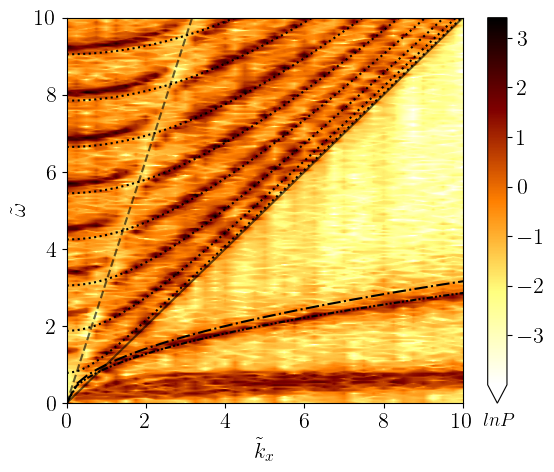

In [ ]:
img.plot(quad=True, detailed=True)

In [ ]:
P = np.load('pdata/P_om_z.npy')